In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import netron
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [7]:
path = "/media/subhaditya/DATA/COSMO/Datasets/signLangNumbers"

In [8]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(flip_vert=False, max_warp=0.0),size = 128)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

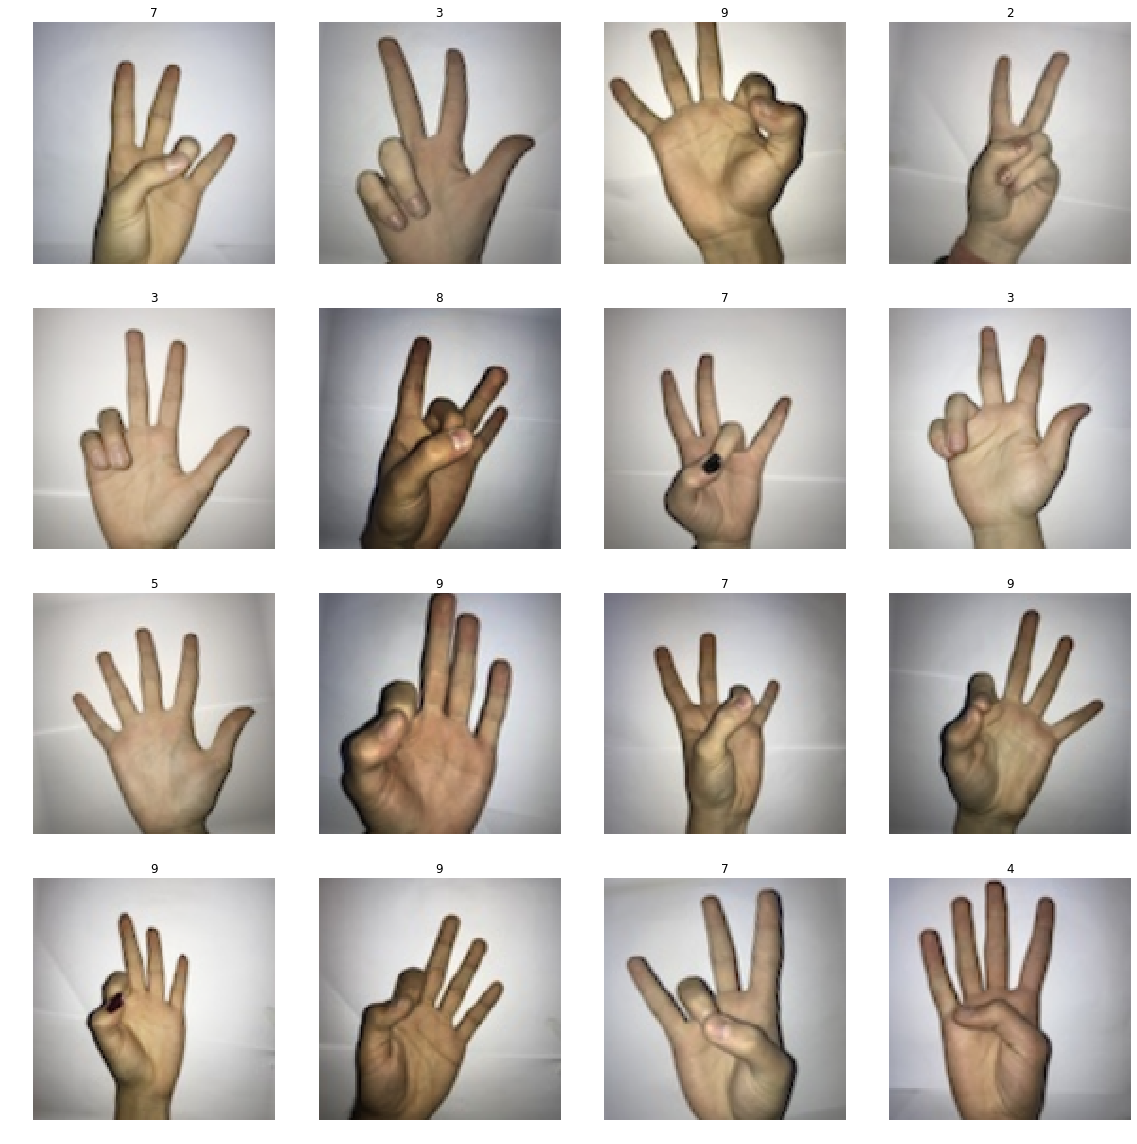

In [9]:
data.show_batch(4)

In [10]:
data.c

11

(array([164., 170., 153., 164., 174., 157., 166., 162., 174., 174.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

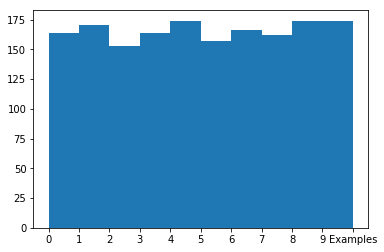

In [14]:
class_sam = [str(x) for x in data.train_ds.y]
plt.hist(class_sam)

## Resnet34

In [11]:
learn = None
gc.collect()

62696

In [12]:
from torch.optim import *

In [13]:
learn = cnn_learner(
    data,
    models.resnet34,
    pretrained=True,
    metrics=[accuracy],
    opt_func=AdamW,
    callback_fns=ShowGraph,
).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


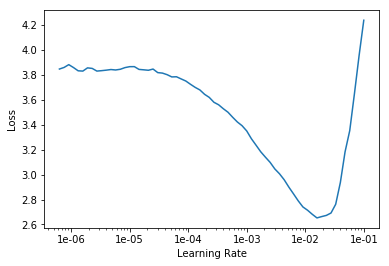

In [15]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.696716,39.195045,0.185990,00:03
1,1.689166,13.086341,0.369565,00:02
2,1.606299,2.519121,0.710145,00:03
3,1.414102,1.504753,0.748792,00:03
4,1.162240,2.490446,0.698068,00:03
5,0.901556,0.870076,0.869565,00:02
6,0.897991,2.302218,0.676328,00:03
7,0.887664,0.728331,0.896135,00:03
8,0.806544,0.975041,0.845411,00:03
9,0.720035,8.312577,0.461353,00:03


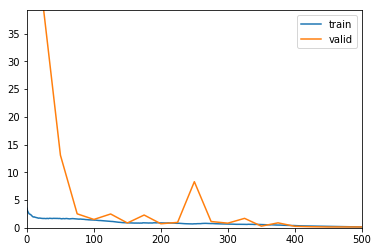

In [16]:
learn.fit_one_cycle(20, 1e-2,wd = 10e-4)

# Efficient NEt

In [26]:
from efficientnet_pytorch import EfficientNet
arch = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
arch._fc = nn.Linear(1280, data.c)

Loaded pretrained weights for efficientnet-b0


In [27]:
learn = None
gc.collect()

14194

(array([164., 170., 153., 164., 174., 157., 166., 162., 174., 174.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

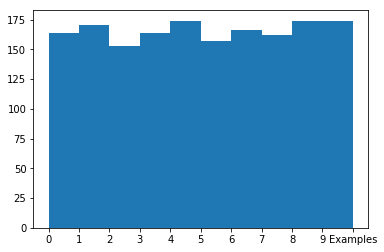

In [19]:
class_sam = [str(x) for x in data.train_ds.y]
plt.hist(class_sam)


In [28]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy,callback_fns = [ShowGraph]).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


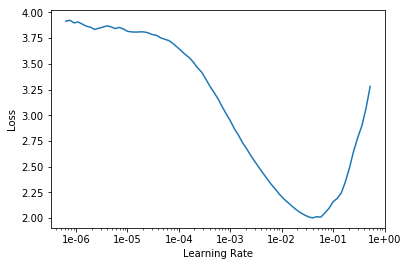

In [29]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.281662,2.264785,0.567633,00:02
1,0.721048,4.327842,0.516908,00:02
2,0.586672,2.205951,0.599034,00:02
3,0.528948,13.492942,0.132850,00:02
4,0.502981,6.083062,0.282609,00:02
5,0.507448,3.300445,0.690821,00:02
6,0.470769,7.508534,0.294686,00:02
7,0.488170,3.083774,0.502415,00:02
8,0.465878,0.848568,0.789855,00:03
9,0.378395,0.271805,0.944444,00:02


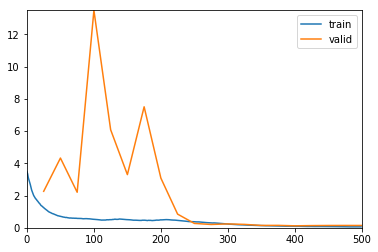

In [30]:
learn.unfreeze()
learn.fit_one_cycle(20, 1e-2, wd = 1e-3)
 

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()
